In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

print("Tensorflow version:{}".format(tf.VERSION))
print("Eager execution:{}".format(tf.executing_eagerly()))

Tensorflow version:1.10.0
Eager execution:True


## 导入和解析训练数据集

In [2]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: C:\Users\dongn\.keras\datasets\iris_training.csv


In [3]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [18]:
def parse_csv(line):
    example_defaults = [[0.], [0.], [0.],[0.], [0]]
    parsed_line = tf.decode_csv(line, example_defaults)
    features = tf.reshape(parsed_line[:-1], shape=(4, ))
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label
print(parse_csv("6.4,2.8,5.6,2.2,2"))

(<tf.Tensor: id=453, shape=(4,), dtype=float32, numpy=array([6.4, 2.8, 5.6, 2.2], dtype=float32)>, <tf.Tensor: id=455, shape=(), dtype=int32, numpy=2>)


In [19]:
# 加载 CSV 格式的文本文件
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
# skip the first line
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)
features, label = iter(train_dataset).next()
print("One features:", features[0])
print("One label:", label[0])

One features: tf.Tensor([6.7 3.1 4.4 1.4], shape=(4,), dtype=float32)
One label: tf.Tensor(1, shape=(), dtype=int32)


## 创建模型

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4, )),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])

## 训练模型

In [20]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.046, Accuracy: 35.000%
Epoch 050: Loss: 0.378, Accuracy: 91.667%
Epoch 100: Loss: 0.248, Accuracy: 97.500%
Epoch 150: Loss: 0.173, Accuracy: 97.500%
Epoch 200: Loss: 0.127, Accuracy: 99.167%


## 图表展示

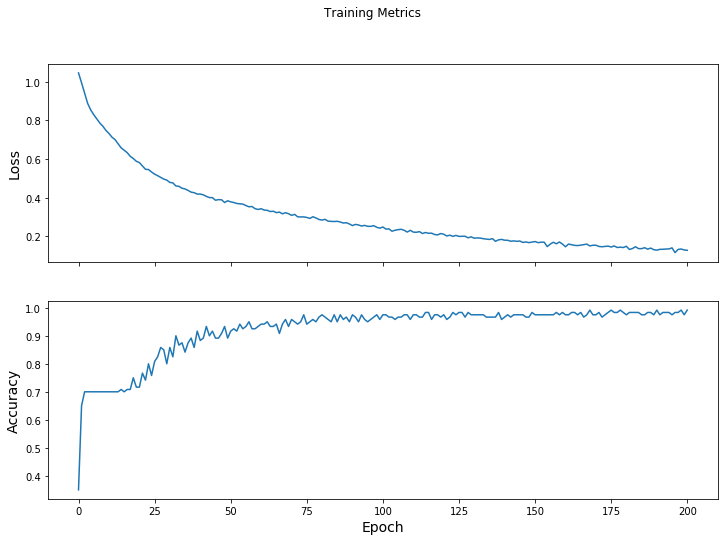

In [22]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)


## 测试数据集

In [25]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

test_accuracy = tfe.metrics.Accuracy()
for (x, y) in test_dataset:
    pre = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(pre, y)
print("Test accracy: {:.3%}".format(test_accuracy.result()))

Test accracy: 96.667%
